In [304]:
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import os
import requests
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame


In [305]:
# Load .env environment variables
load_dotenv()

True

In [306]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [307]:
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [308]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [309]:
# create a function to pull stock data from the alpaca api
def get_company(ticker, start, end, tradeapi):
    return alpaca.get_bars(
        ticker,
        TimeFrame.Day,
        start,
        end
    ).df

In [310]:
# Set your ticker and format start and end dates in iso format
# Set dates to pull 5 years of data
msft_ticker = ["MSFT"]
start= pd.Timestamp("2017-06-01", tz="America/New_York").isoformat()
end= pd.Timestamp("2022-06-01", tz="America/New_York").isoformat()

In [311]:
# Get stock data for Microsoft
msft_df = get_company(msft_ticker, start, end, tradeapi)

# Drop columns that we will not need
msft_df= msft_df.drop(["trade_count", "vwap"], axis=1)

# Resample the data to show monthly average
msft_mnth_df = pd.DataFrame(msft_df.resample("M").mean())

# Show microsoft stock data

msft_mnth_df.head()

,open,high,low,close,volume
timestamp,,,,,
2017-06-30 00:00:00+00:00,70.589091,71.014600,69.835727,70.518182,2.876127e+07
2017-07-31 00:00:00+00:00,71.841000,75.105495,69.496500,72.010500,2.349984e+07
2017-08-31 00:00:00+00:00,72.709565,73.196083,72.285187,72.816957,1.932927e+07
2017-09-30 00:00:00+00:00,74.375500,74.786000,73.891000,74.344500,1.885708e+07
2017-10-31 00:00:00+00:00,77.876818,78.349318,77.529773,77.939545,2.053351e+07


In [312]:
# Create a new df filtering the index and close columns
msft_signals_df = msft_df.loc[:, ["close"]]

# Create a column for the daily returns
msft_signals_df["Actual Returns"] = msft_df["close"].pct_change()

# Drop all NaN values from the DataFrame
msft_signals_df = msft_signals_df.dropna()

# Show signals df
display(msft_signals_df.head())
display(msft_signals_df.tail())

,close,Actual Returns
timestamp,,
2017-06-02 04:00:00+00:00,71.76,0.023680
2017-06-05 04:00:00+00:00,72.28,0.007246
2017-06-06 04:00:00+00:00,72.52,0.003320
2017-06-07 04:00:00+00:00,72.39,-0.001793
2017-06-08 04:00:00+00:00,71.95,-0.006078


,close,Actual Returns
timestamp,,
2022-05-25 04:00:00+00:00,262.52,0.011170
2022-05-26 04:00:00+00:00,265.90,0.012875
2022-05-27 04:00:00+00:00,273.24,0.027604
2022-05-31 04:00:00+00:00,271.87,-0.005014
2022-06-01 04:00:00+00:00,272.42,0.002023


In [313]:
# set the windows for moving averages
short_window= 20
long_window= 50

# Generate the short and long simple moving averages
msft_signals_df["SMA_short"] = msft_signals_df["close"].rolling(window=short_window).mean()
msft_signals_df["SMA_long"] = msft_signals_df["close"].rolling(window=long_window).mean()
msft_signals_df = msft_signals_df.dropna()
msft_signals_df.head()


,close,Actual Returns,SMA_short,SMA_long
timestamp,,,,
2017-08-11 04:00:00+00:00,72.50,0.015264,73.0250,71.4550
2017-08-14 04:00:00+00:00,73.59,0.015034,73.0370,71.4916
2017-08-15 04:00:00+00:00,73.22,-0.005028,73.0330,71.5104
2017-08-16 04:00:00+00:00,73.65,0.005873,73.0225,71.5330
2017-08-17 04:00:00+00:00,72.40,-0.016972,72.9315,71.5332


<AxesSubplot:xlabel='timestamp'>

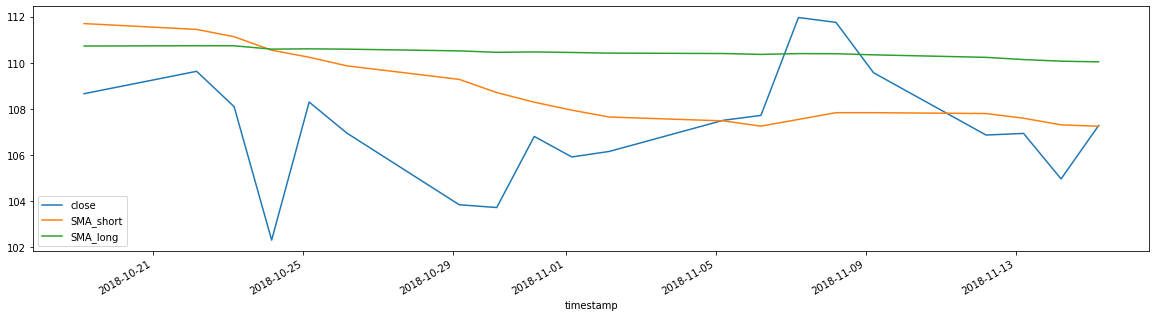

In [314]:
# Plot the SMA's with the historical close price
# Do these indicators work for our algorithm? What else will work?
msft_signals_df[["close", "SMA_short", "SMA_long"]].iloc[300:320].plot(figsize=(20,5))

In [315]:
# EWMA indicators
short_span = 8
long_span = 20
smooth_span = 4
msft_ewma_df = msft_df.loc[:, ["close"]]
msft_ewma_df['8EWMA'] = msft_ewma_df['close'].ewm(span= short_span).mean()
msft_ewma_df['20EWMA'] = msft_ewma_df['close'].ewm(span= long_span).mean()

<AxesSubplot:xlabel='timestamp'>

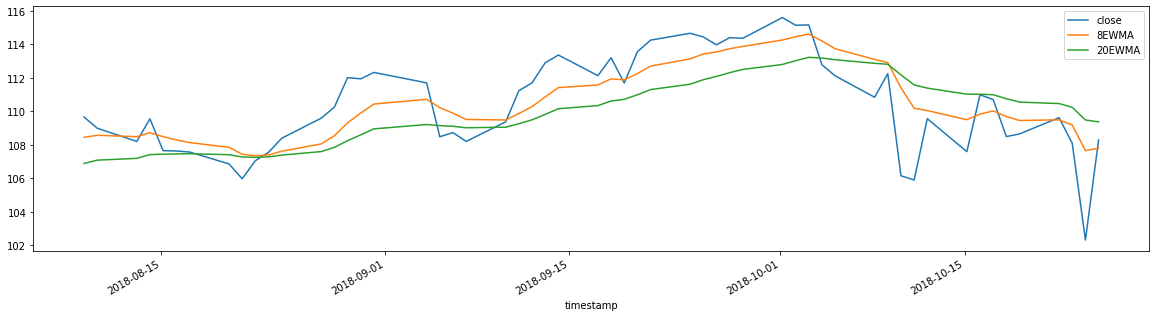

In [316]:
# Plot the EWMA indicators
msft_ewma_df[["close", "8EWMA", "20EWMA"]].iloc[300:355].plot(figsize=(20,5))

In [317]:
# It appears that the indicators have potential for a signal when close price surpasses both indicators. This signal is much stronger for
# the uptrends than the downtrends (based on visuals of historical pricing data). Will need to add MACD indicator to help with signal confirmation.
# Next steps: decide what indicators we will use, generate the signals

In [318]:
msft_ewma_df['Signal'] = 0.0
msft_ewma_df['Signal'][short_window:] = np.where(msft_ewma_df['close'][short_window:] > msft_ewma_df['8EWMA'][short_window:], 1.0, 0.0
)


In [319]:
msft_ewma_df.tail()

,close,8EWMA,20EWMA,Signal
timestamp,,,,
2022-05-25 04:00:00+00:00,262.52,260.173906,266.336119,1.0
2022-05-26 04:00:00+00:00,265.90,261.446371,266.294584,1.0
2022-05-27 04:00:00+00:00,273.24,264.067178,266.956052,1.0
2022-05-31 04:00:00+00:00,271.87,265.801138,267.424047,1.0
2022-06-01 04:00:00+00:00,272.42,267.271996,267.899852,1.0


,macd,signal,hist
timestamp,,,
2017-06-01 04:00:00+00:00,0.000000,0.000000,0.000000
2017-06-02 04:00:00+00:00,0.210794,0.084317,0.126476
2017-06-05 04:00:00+00:00,0.420700,0.218871,0.201830
2017-06-06 04:00:00+00:00,0.589985,0.367316,0.222669
2017-06-07 04:00:00+00:00,0.680117,0.492437,0.187680
